In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from collections import defaultdict
import itertools
import ast
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
features_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/features_df.csv')

In [ ]:
import ast

def clean_features(features):
    try:
        # Attempt to interpret the string as a literal Python list
        features = ast.literal_eval(features)
    except (SyntaxError, ValueError):
        # If it's not a valid list string, keep it as is
        pass

    if isinstance(features, list):
        return [str(feature).strip() for feature in features if isinstance(feature, str)]
    else:
        return [str(features).strip()]

features_df['all_features'] = features_df['all_features'].apply(clean_features)

In [ ]:
features_df.head(10)

appid                                       all_features   category  \
0    8980  [structure, online_multiplayer, graphical, sci...  non-indie   
1   24880  [Time Investment, Purchase Decisions, Enjoymen...  non-indie   
2  251570  [structure, online_multiplayer, creative tools...      indie   
3  251950  [gamplay, graphical, strategy, online_multipla...      indie   
4  269770  [structure, gamplay, online_multiplayer, turn-...      indie   
5  276870  [structure, Game Progression and Challenges, T...      indie   
6  282880  [Enjoyment and Social Play, Game Challenge, Ga...      indie   
7  290100  [structure, graphical, strategy, exploration, ...      indie   
8  299080  [structure, investigative, psychological thril...  non-indie   
9  304390  [structure, online_multiplayer, graphical, str...  non-indie   

   success  
0        0  
1        0  
2        1  
3        0  
4        0  
5        0  
6        1  
7        0  
8        0  
9        0

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=features_df)

https://docs.google.com/spreadsheets/d/1N6YHCTJ3YatI-5RbRTPaPpxBvXfdbwuFqDV-6XLByfM#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
def plot_graph(graph, title):
    pos = nx.spring_layout(graph, k=0.5, iterations=100)

    # Create edges
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # Prevents lines from connecting across nodes
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create nodes
    node_x = []
    node_y = []
    node_color = []
    node_text = []

    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(graph.nodes[node]['color'])
        node_text.append(node)  # Display feature name

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=10,
            line_width=2),
        text=node_text)

    # Create Network Graph
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'<br>{title}',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [ ]:
# Filter for each category and success combination:
indie_df = features_df[features_df['category'] == 'indie']
non_indie_df = features_df[features_df['category'] != 'indie']

In [ ]:
success_counts = features_df['success'].value_counts()
print("Distribution of success values:")
print(success_counts)

Distribution of success values:
success
0    10752
1      642
Name: count, dtype: int64


In [ ]:
def create_combined_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        features = row['all_features']

        # Add nodes for each feature with success and failure suffix
        for feature in features:
            success_node = f"{feature}_success"
            failure_node = f"{feature}_failure"
            G.add_node(success_node, color='green')  # Color for success
            G.add_node(failure_node, color='red')  # Color for failure

        # Create edges for co-occurrences
        for feature1, feature2 in itertools.combinations(features, 2):
            # Link success edges
            if row['success'] == 1:
                if G.has_edge(f"{feature1}_success", f"{feature2}_success"):
                    G[f"{feature1}_success"][f"{feature2}_success"]['weight'] += 1
                else:
                    G.add_edge(f"{feature1}_success", f"{feature2}_success", weight=1)
            else:
                if G.has_edge(f"{feature1}_failure", f"{feature2}_failure"):
                    G[f"{feature1}_failure"][f"{feature2}_failure"]['weight'] += 1
                else:
                    G.add_edge(f"{feature1}_failure", f"{feature2}_failure", weight=1)

            # Link success to failure nodes and vice versa
            if G.has_edge(f"{feature1}_success", f"{feature2}_failure"):
                G[f"{feature1}_success"][f"{feature2}_failure"]['weight'] += 1
            else:
                G.add_edge(f"{feature1}_success", f"{feature2}_failure", weight=1)

            if G.has_edge(f"{feature1}_failure", f"{feature2}_success"):
                G[f"{feature1}_failure"][f"{feature2}_success"]['weight'] += 1
            else:
                G.add_edge(f"{feature1}_failure", f"{feature2}_success", weight=1)

    return G

In [ ]:
indie_graph = create_combined_graph(indie_df)
non_indie_graph = create_combined_graph(non_indie_df)

In [ ]:
def analyze_edge_weights(graph, title='Edge Weight Distribution'):
    edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    plt.figure(figsize=(10, 6))
    plt.hist(edge_weights, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Weight')
    plt.ylabel('Frequency')

    if edge_weights:
        threshold = np.percentile(edge_weights, 50)
        plt.axvline(x=threshold, color='red', linestyle='--', label='50th Percentile')
        plt.legend()
        plt.show()
        return threshold
    return None


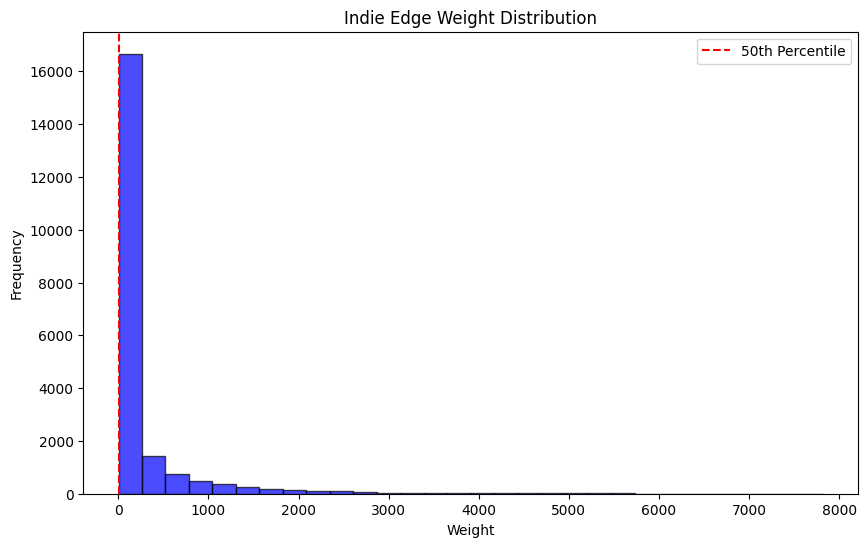

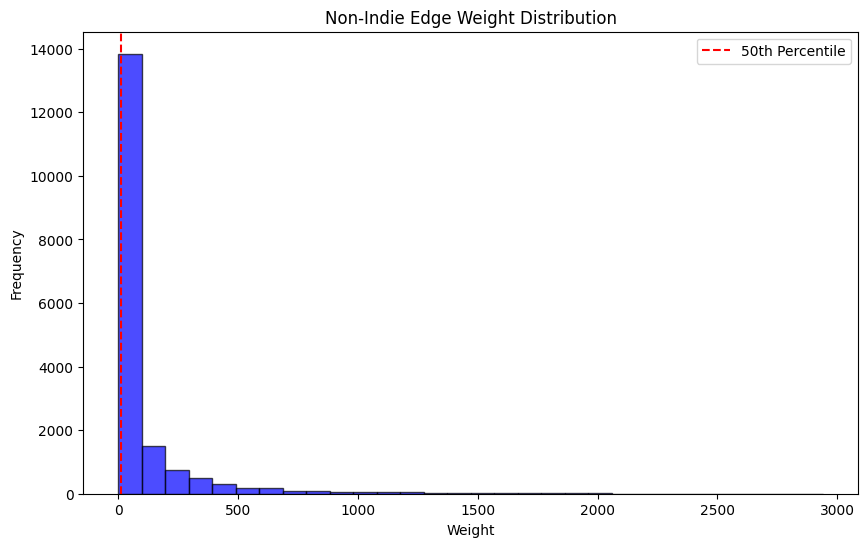

In [ ]:
# Set thresholds for indie and non-indie graphs
indie_threshold = analyze_edge_weights(indie_graph, "Indie Edge Weight Distribution")
non_indie_threshold = analyze_edge_weights(non_indie_graph, "Non-Indie Edge Weight Distribution")


In [ ]:
# Function to filter edges by weight threshold
def filter_edges_by_weight(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

# Filter edges for both graphs based on their respective thresholds
filter_edges_by_weight(indie_graph, indie_threshold)
filter_edges_by_weight(non_indie_graph, non_indie_threshold)


In [ ]:
def plot_graph(graph, title):
    pos = nx.spring_layout(graph, k=0.5, iterations=100)  # Adjust k for spacing

    # Create edges
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # Prevents lines from connecting across nodes
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create nodes
    node_x = []
    node_y = []
    node_color = []
    node_text = []

    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(graph.nodes[node]['color'])  # Color for success or failure
        node_text.append(node)  # Display feature name

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=10,
            line_width=2),
        text=node_text)

    # Create Network Graph
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'<br>{title}',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [ ]:
plot_graph(indie_graph, 'Indie Features by Game Success and Failure')

In [ ]:
plot_graph(non_indie_graph, 'Non-Indie Features by Game Success and Failure')

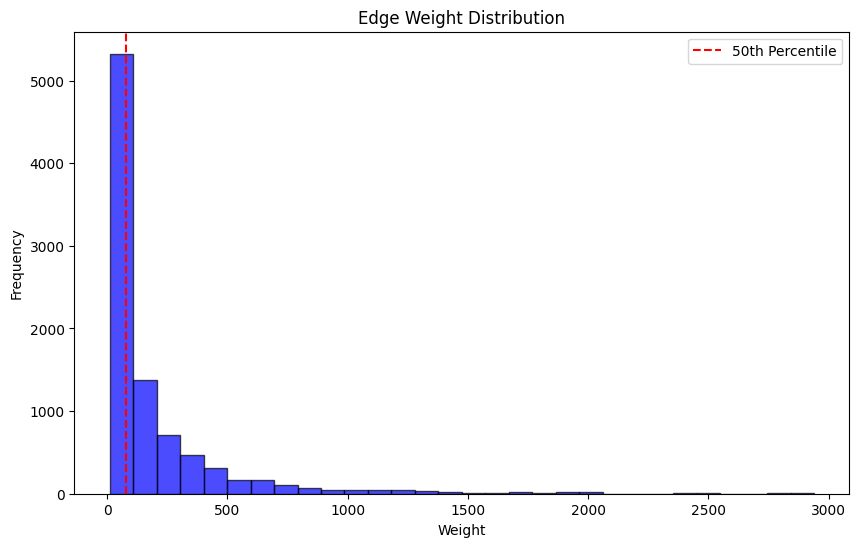

In [ ]:
non_indie_threshold = analyze_edge_weights(non_indie_graph)

In [ ]:
def filter_edges_by_weight(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

In [ ]:
filter_edges_by_weight(indie_graph, indie_threshold)
filter_edges_by_weight(non_indie_graph, non_indie_threshold)

In [ ]:
plot_graph(indie_graph, 'Combined Indie Features')

In [ ]:
plot_graph(non_indie_graph, 'Combined Non-Indie Features')

In [ ]:
plot_graph(non_indie_success_graph, 'Non-Indie - Success')

NameError: name 'non_indie_success_graph' is not defined

In [ ]:
plot_graph(non_indie_failure_graph, 'Non-Indie - Failure')